In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', 200)

In [2]:
dtypes = {
    'session_id': 'category',
    'elapsed_time': np.int32,
    'event_name': 'category',
    'level': np.uint8,
    'text': 'category',
    'level_group': 'category'
}
cols_to_use = ['session_id', 'index', 'elapsed_time', 'event_name', 'level', 'text', 'level_group']
eda_df = pd.read_csv("/Users/macintosh/Desktop/data_completitions/Kaggle/2023/predict-student-performance-from-game-play/train.csv", usecols=cols_to_use, dtype=dtypes)

In [3]:
# Set level colour
N_SESS = eda_df['session_id'].nunique()
LEVELS = range(23)
LV_COLORS = plt.cm.get_cmap('hsv', len(LEVELS))

In [4]:
pk_temp = ['session_id', 'index']
# eda_df.loc[eda_df.duplicated(subset=pk_temp)].groupby('session_id').index.count().sort_values(ascending=False).head()
assert not eda_df.duplicated(subset=pk_temp).any()

AssertionError: 

In [5]:
# Duplicate Session ID, Index pair
sess_dup = eda_df.loc[eda_df.duplicated(subset=pk_temp, keep=False)].session_id.unique().tolist()
eda_dup = eda_df[eda_df.session_id.isin(sess_dup)].reset_index(drop=True)
print(f'Session id pair duplicate is : {len(sess_dup)}')

Session id pair duplicate is : 142


In [6]:
# n_rows, n_cols = 29, 5
# fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 80))
# # Group df to each session_id by eda_dup.groupby('session_id', observed=True)
# # Use enumerate to get index
# for i, (session_id, gp) in enumerate(eda_dup.groupby('session_id', observed=True)):
#     gp = gp.reset_index(drop=True)
#     # Use to find axis x, y for create graph
#     axis[i // n_cols, i % n_cols].plot(gp['index'])
#     axis[i // n_cols, i % n_cols].set_title(f'Even Index of Session {session_id}\n Min Index {gp["index"].min()}')
#     axis[i // n_cols, i % n_cols].set_xlabel(f'Event Ordering in DataFrame')
#     axis[i // n_cols, i % n_cols].set_ylabel(f'Event Index')
#     plt.tight_layout()

In [79]:
# Reverse Index
session_with_reversed_index = []
for session_id, gp in eda_df.groupby('session_id', observed=True):
    if not gp['index'].is_monotonic_decreasing:
        session_with_reversed_index.append(session_id)
print(f'Not monotonic increase session: {len(session_with_reversed_index)}')

In [35]:
for i in eda_dup.groupby('session_id', observed=True):
    print(i[1].reset_index(drop=True))
    # print(i[1])
    break

             session_id  index  elapsed_time      event_name  level   
0     20110422113670820      0             0  cutscene_click      0  \
1     20110422113670820      1           297    person_click      0   
2     20110422113670820      2           546    person_click      0   
3     20110422113670820      3           757    person_click      0   
4     20110422113670820      4          1010    person_click      0   
...                 ...    ...           ...             ...    ...   
1561  20110422113670820    463       1541915  navigate_click     22   
1562  20110422113670820    464       1542101  navigate_click     22   
1563  20110422113670820    465       1542532  navigate_click     22   
1564  20110422113670820    466       1543522  navigate_click     22   
1565  20110422113670820    467       1543725      checkpoint     22   

                               text level_group  
0                         undefined         0-4  
1     Whatcha doing over there, Jo?         0-4

In [ ]:
ckpt_valid_mask = (n_ckpts_per_sess["0-4"] == 1) & (n_ckpts_per_sess["5-12"] == 1) & (n_ckpts_per_sess["13-22"] == 1)
sess_with_invalid_ckpt = n_ckpts_per_sess.loc[~ckpt_valid_mask].index.astype(int).tolist()
print(f"There are {len(sess_with_invalid_ckpt)} sessions with less than or more than 3 checkpoints.")

1

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

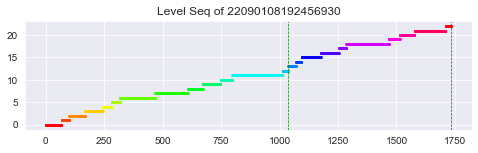

In [56]:
6 % 5